In [25]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/press


In [26]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.visualization import plot_action
from express.utils import add_names
import express.config as config

In [27]:
model = "xgboost" #"xgboost"
trial = 4

save_path = os.path.join(base_path, "stores", "model", model, f"{trial:03d}", "component.pkl")
path = Path(save_path)
component = pickle.load(path.open(mode="rb"))
component

In [28]:
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

if model == "xgboost":
    xfns = ["startlocation", "closest_11_players"]
    nb_prev_actions = 3
elif model == "soccermap":
    xfns = ["startlocation", "freeze_frame_360"]
    nb_prev_actions = 1

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=xfns,
    yfns=["counterpress"],
    load_cached=True,
    nb_prev_actions=nb_prev_actions
)

print(f"Test DataSet: {test_dataset.features.shape}")
print(f"Test Dataset: {test_dataset.labels.value_counts().to_dict()}")

Test DataSet: (12406, 195)
Test Dataset: {(False,): 9954, (True,): 2452}


In [29]:
component.test(dataset_test)

{'precision': 0.7106681034482759,
 'recall': 0.5379282218597063,
 'f1': 0.6123491179201485,
 'log_loss': 0.3166872054471614,
 'brier': 0.09556845523801184,
 'roc_auc': 0.8953104140383448}

<Axes: title={'center': 'pressing & fail: 0.12069'}>

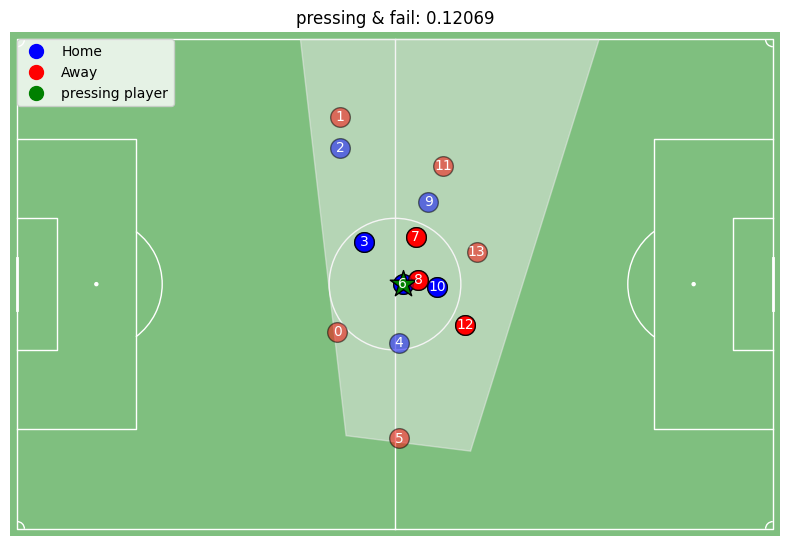

In [30]:
game_id = 3895202
action_id = 555
actions = add_names(test_db.actions(3895202))
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)

prob = component.predict(dataset_test).loc[(game_id, action_id)].iloc[0]
plot_action(actions.loc[(game_id, action_id)], home_team_id=home_team_id, prob=prob)

In [ ]:
from express.simulates import expressXGBoostComponent

simulate = expressXGBoostComponent(component, 
                                   db= test_db,
                                   xfns= test_dataset.xfns.keys(),
                                   nb_prev_actions=nb_prev_actions)


freeze_frame_idx = 6
freeze_frame_360 = pd.DataFrame(actions.loc[(game_id, action_id)]["freeze_frame_360"])
x, y = freeze_frame_360.loc[freeze_frame_idx, ["x", "y"]]
dx_range = range(-5, 5)  
dy_range = range(-5, 5)
xy = [(x + dx, y + dy) for dx in dx_range for dy in dy_range]

simulated_instances = simulate.simulate(game_id= game_id, action_id= action_id, 
                                     freeze_frame_idx= freeze_frame_idx, xy= xy)
simulated_instances

100%|██████████| 100/100 [00:02<00:00, 43.17it/s]


In [12]:
raw_instance = next((instance for instance in simulated_instances if instance.raw), None)
if not raw_instance:
    raise ValueError("raw가 True인 인스턴스가 없습니다.")

k = 8
sorted_instances = sorted(
    [instance for instance in simulated_instances if not instance.raw],
    key=lambda x: x.prob,
    reverse=True
)

instances = [raw_instance] + sorted_instances[:k]
instances

In [13]:

def _fix_direction_of_play(actions: pd.DataFrame, home_team_id: int) -> pd.DataFrame:
    away_idx = (actions.team_id != home_team_id).values
    for col in ["start_x", "end_x"]:
        actions.loc[away_idx, col] = config.field_length - actions[away_idx][col].values
    for col in ["start_y", "end_y"]:
        actions.loc[away_idx, col] = config.field_width - actions[away_idx][col].values

    return actions

def _sb_freeze_frame_to_spadl(freeze_frame,invert: bool = False):
    if not isinstance(freeze_frame, list):
        return None
    freezedf = pd.DataFrame(
        {
            "teammate": e["teammate"],
            "actor": e["actor"],
            "keeper": e["keeper"],
            "x": e["x"],
            "y": e["y"],
        }
        for e in freeze_frame
    )

    if invert:
        freezedf["x"] = config.field_length - freezedf["x"].values
        freezedf["y"] = config.field_width - freezedf["y"].values
    return list(freezedf.to_dict("records"))

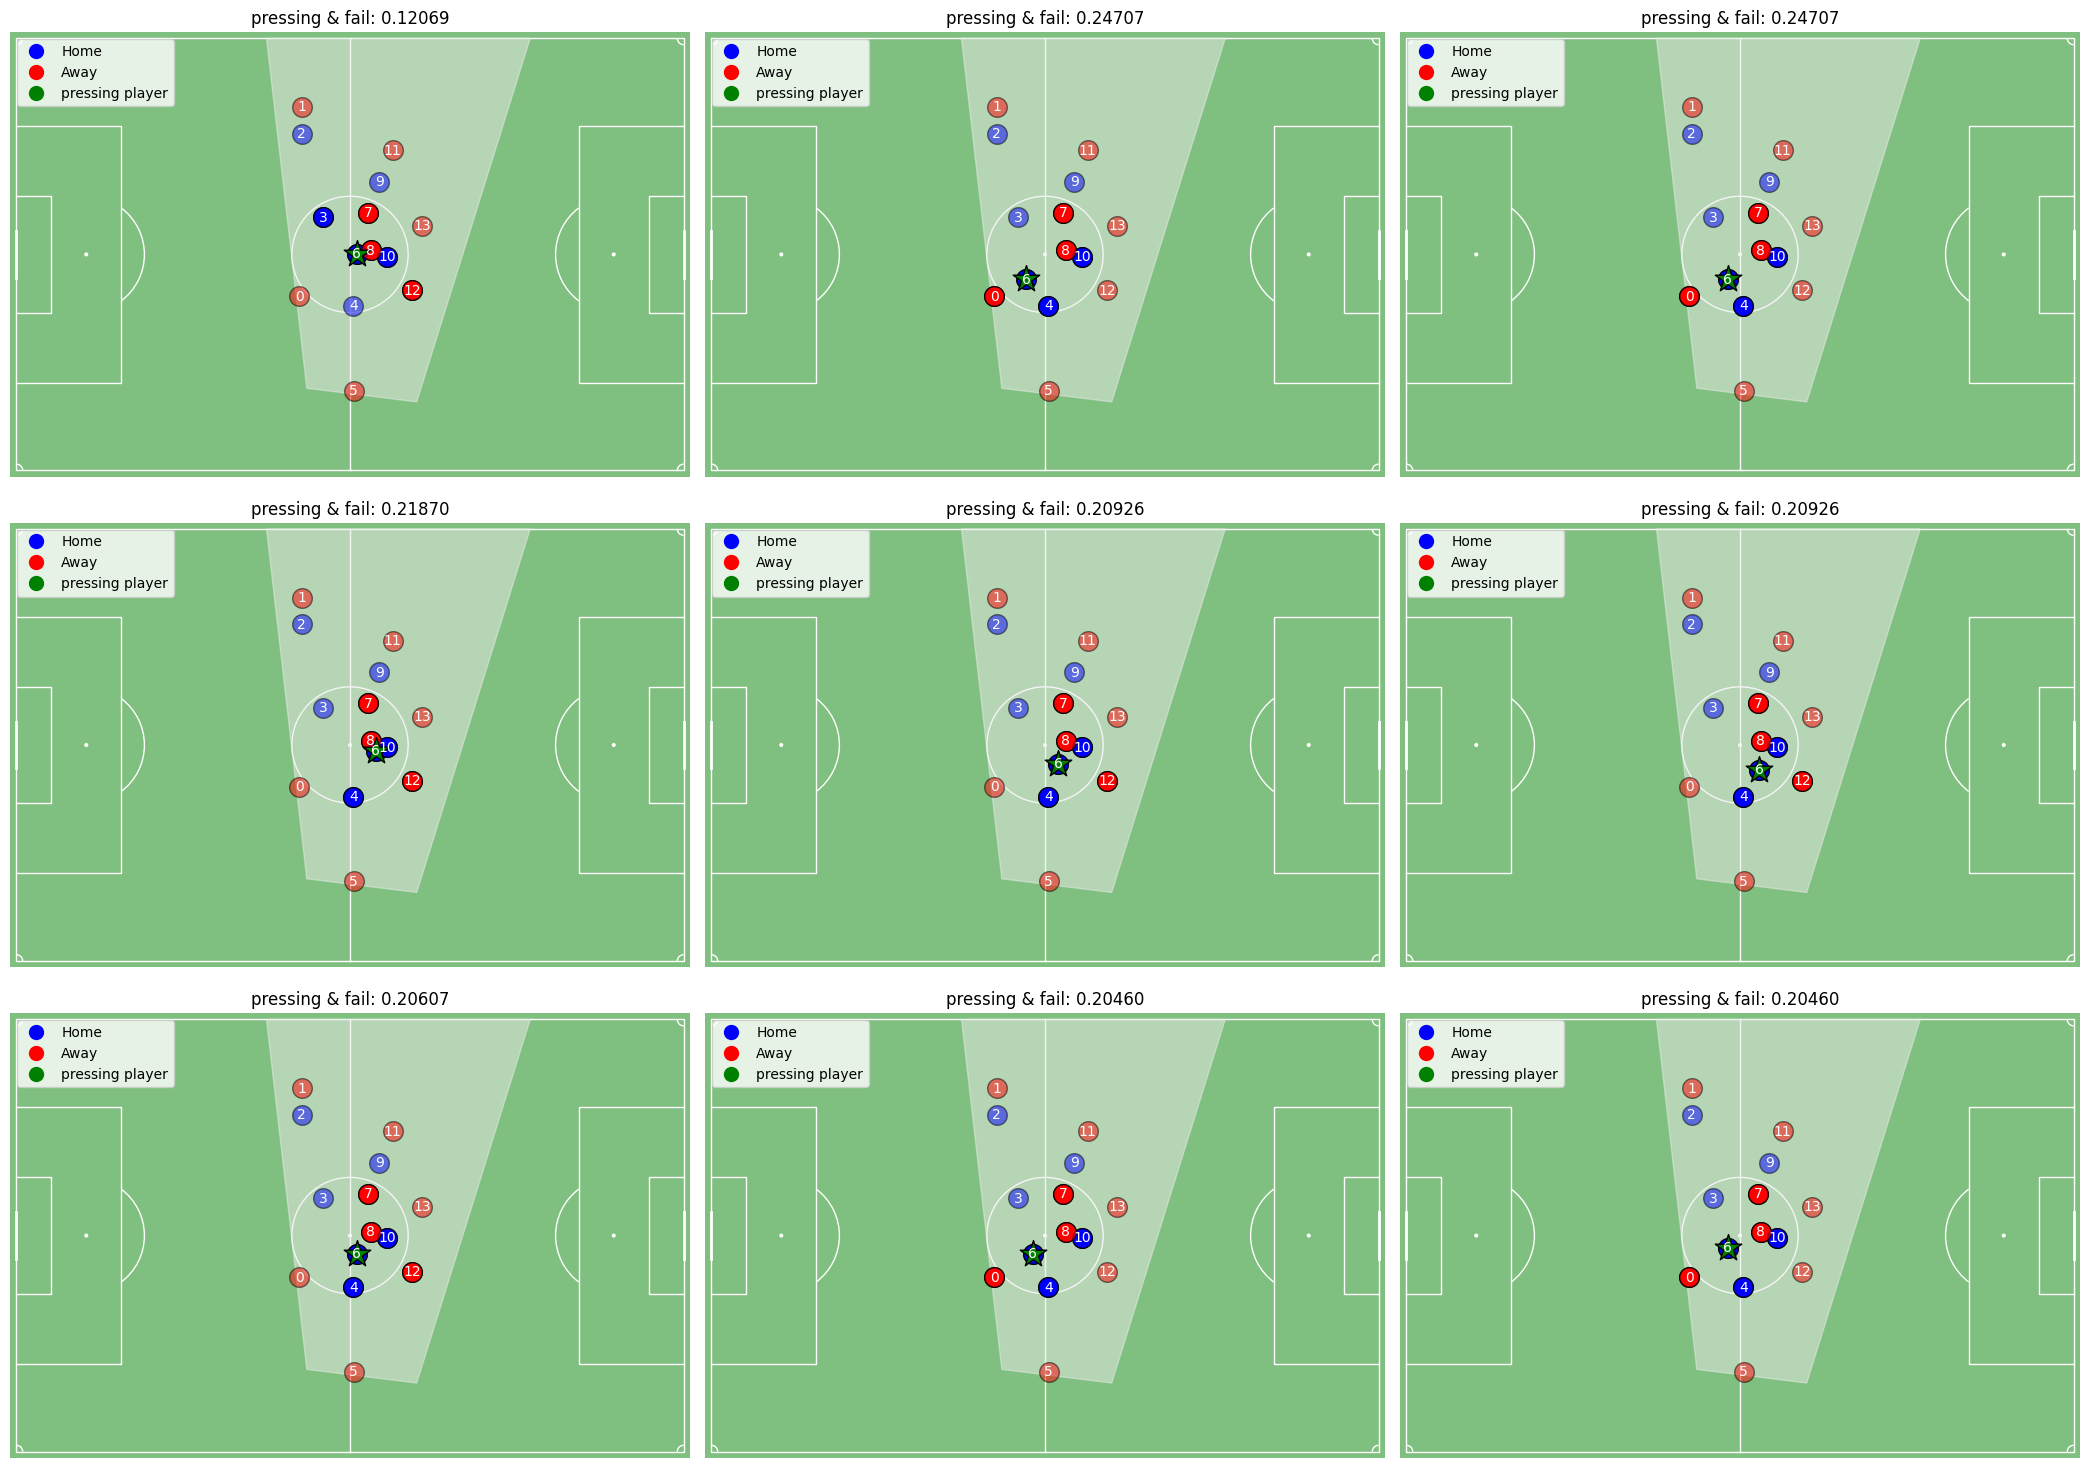

In [14]:
cols = int(k ** 0.5) + 1  # 가로
rows = (k + cols - 1) // cols  # 세로

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten()

for i, instance in enumerate(instances):
    print(instance)
    action = instance.data # 모든 플레이가 왼쪽에서 오른쪽으로 플레이되므로..다시 원정은 오른쪽으로 변환
    # action = _fix_direction_of_play(action, home_team_id)
    # action["freeze_frame_360"] = action.assign(away_idx=(action.team_id != home_team_id)).apply(
    #     lambda x: _sb_freeze_frame_to_spadl(x.freeze_frame_360, x.away_idx), axis=1
    # )
    prob = instance.prob

    plot_action(
        action= action.squeeze(),
        home_team_id=home_team_id,
        prob=prob,
        ax=axes[i]
    )
    

    # title_prefix = "Raw Data" if (row["dx"] == 0 and row["dy"] == 0) else f"Top {i}"
    # axes[i].set_title(f"{title_prefix} (prob: {row['probability']:.2f})")

# 레이아웃 조정
plt.tight_layout()
plt.show()


### Application

In [ ]:
idx = (3857255, 6)

sample_features = {}
sample_target = {}
sample_features = test_dataset.features.loc[idx].to_dict()
game_id, action_id = test_dataset.features.loc[idx].name

sample_target = test_dataset.labels.loc[idx].to_dict()
game_id, action_id = test_dataset.labels.loc[idx].name

sample = {
    "game_id": game_id,
    "action_id": action_id,
    **sample_features,
    **sample_target,
}
sample

{'game_id': 3857255,
 'action_id': 6,
 'start_x_a0': 85.66250000000001,
 'start_y_a0': 55.76,
 'freeze_frame_360_a0': array([{'actor': False, 'keeper': False, 'teammate': False, 'x': 66.40263608328932, 'y': 46.094567866742004},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 68.17524134820296, 'y': 68.74704611379114},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 69.83990236633127, 'y': 18.606095649369955},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 82.67555632026671, 'y': 34.41405393462132},
        {'actor': True, 'keeper': False, 'teammate': True, 'x': 86.10000133514404, 'y': 55.335000324249265},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 89.46524650507118, 'y': 56.63345693562979}],
       dtype=object),
 'counterpress': False}

In [ ]:
from express.components.soccermap import ToSoccerMapTensor
transform = ToSoccerMapTensor(dim=(68, 104))

tensor_data = transform(sample)[0][7]

print(tensor_data.shape)
tensor_data

torch.Size([68, 104])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
component.model(transform(sample)[0])

tensor([[0.0814]], grad_fn=<SigmoidBackward0>)

In [ ]:
df_pred = pd.DataFrame(y_pred, index=test_dataset.features.index, columns=test_dataset.labels.columns)
df_pred

counterpress
game_id action_id              
3857255 6              0.081361
        17             0.078102
        22             0.134558
        25             0.110227
        40             0.102862
...                         ...
3895348 2818           0.062434
        2834           0.115184
        2847           0.041475
        2848           0.095037
        2853           0.555428

[12406 rows x 1 columns]

In [ ]:
game_ids = list(df_pred.index.get_level_values('game_id').unique())
game_id = 3857255#game_ids[0]

print(game_id)
df_actions = add_names(test_db.actions(game_id)).reset_index()
df_actions.head()

3857255


,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3857255,0,8b26aef6-09bc-4cc7-87a8-2b547c0b44f7,1,0.540,772,133353,52.0625,33.660,78.9250,...,From Kick Off,0,1.793392,"{'pass': {'recipient': {'id': 6892, 'name': 'P...","[[89.57332889084125, 68.0], [68.77267355099548...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
1,3857255,1,da8a2bc2-28d0-48f8-8d69-522e47530e2a,1,2.334,772,6892,78.9250,27.200,76.1250,...,From Kick Off,0,1.389570,"{'carry': {'end_location': [33.5, 32.7]}}","[[99.64777529798958, 68.0], [75.35694264065879...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",dribble,success,foot
2,3857255,2,57365d40-4701-486a-8c96-ed35af64f4eb,1,3.723,772,6892,76.1250,27.370,31.4125,...,From Kick Off,0,2.655969,"{'pass': {'recipient': {'id': 68574, 'name': '...","[[99.83713280330954, 68.0], [75.42532118557196...",0,"[{'teammate': True, 'actor': True, 'keeper': F...",pass,fail,foot_left
3,3857255,3,368d9a8b-7c8e-4dc2-9363-8aac056dae54,1,6.379,778,5690,30.6250,61.200,62.0375,...,From Kick Off,1,0.000000,"{'clearance': {'head': True, 'body_part': {'id...","[[28.21450064148319, 6.3044786146363805], [3.2...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",clearance,success,head
4,3857255,4,5aff0d66-50f1-4b05-893d-266b0964519a,1,12.931,772,3957,62.0375,67.575,76.4750,...,From Throw In,0,1.003935,"{'pass': {'recipient': {'id': 6765, 'name': 'R...","[[83.76973182280807, 68.0], [69.07632091801368...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",throw_in,success,other


In [ ]:
pd.DataFrame(df_actions.loc[pressure_idx]["freeze_frame_360"])

,teammate,actor,keeper,x,y
0,False,False,False,66.402636,46.094568
1,False,False,False,68.175241,68.747046
2,False,False,False,69.839902,18.606096
3,False,False,False,82.675556,34.414054
4,True,True,False,86.100001,55.335000
5,False,False,False,89.465247,56.633457


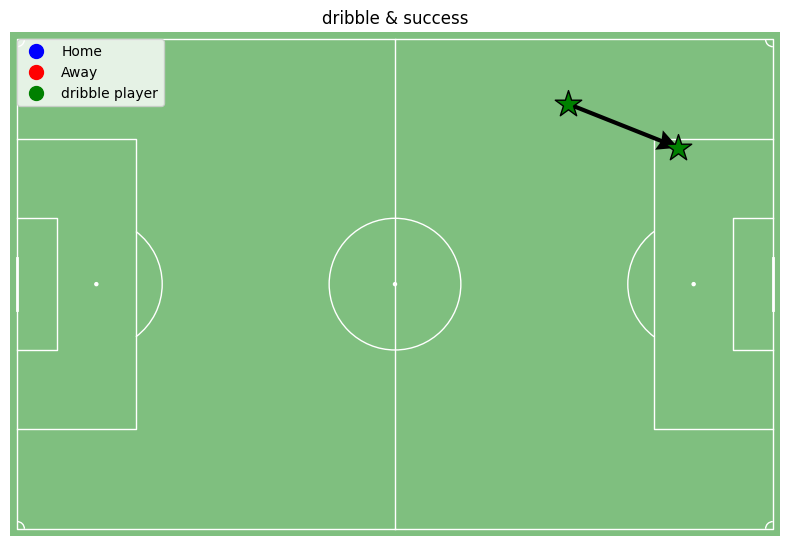

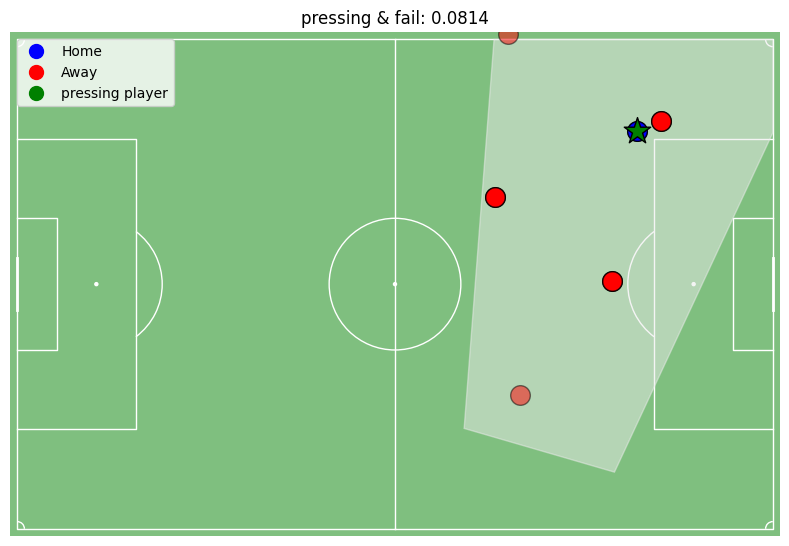

In [ ]:
condition = (df_actions["type_name"] == "pressing")
# condition = (df_actions["type_name"] == "pressing") & (df_actions["result_name"] == "success")
# condition = (df_actions["action_id"] == 1609)
pressure_idx = df_actions[condition].index[0]

home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)

for idx in range(pressure_idx-1, pressure_idx+1):
    in_visible_area_360 = df_actions.loc[idx]["in_visible_area_360"]
    actiontype_id = df_actions.at[idx, "type_id"]
    index = tuple(df_actions.loc[idx, ["game_id", "action_id"]].values)
    prob = df_pred.loc[index, "counterpress"] if actiontype_id == config.actiontypes.index("pressing") else None

    plot_action(df_actions.loc[idx], show_visible_area=in_visible_area_360, home_team_id=home_team_id, prob=prob)